# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

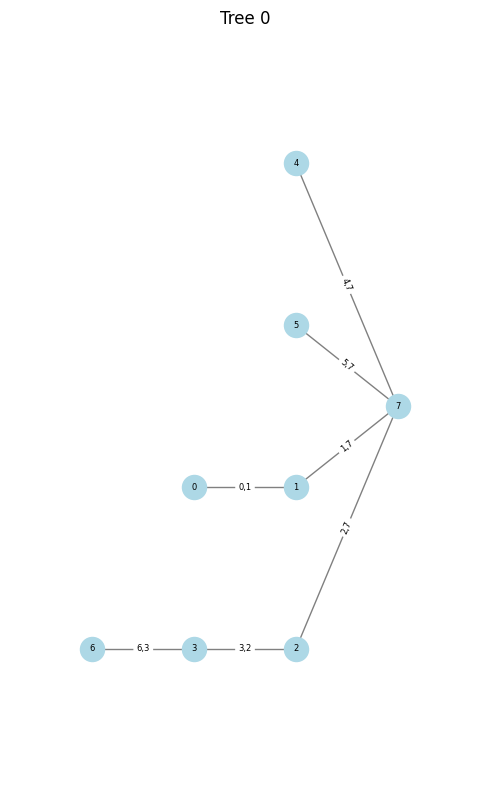

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-17 13:11:26,787] A new study created in RDB with name: no-name-db6780db-6dc1-4dc4-a3e4-dbe71d1b2c2b
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 4/2000 [00:00<03:04, 10.82it/s]

current_loss: tensor(1.4464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4482134580612183
current_loss: tensor(1.4457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4453614950180054
current_loss: tensor(1.4418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4390066862106323
current_loss: tensor(1.4349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.437707543373108


  0%|          | 7/2000 [00:00<02:14, 14.83it/s]

current_loss: tensor(1.4343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.437332034111023
current_loss: tensor(1.4339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4374486207962036
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4372532367706299
current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4371870756149292
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0

  1%|          | 13/2000 [00:00<02:04, 15.98it/s]


current_loss_val:  1.4369326829910278
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.436988353729248
current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4370756149291992
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4371381998062134
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4371449947357178
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.437338829

  0%|          | 1/2000 [00:00<05:50,  5.70it/s]

current_loss: tensor(1.4340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.348183512687683
current_loss: tensor(1.3442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147108316421509
current_loss: tensor(1.2192, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:55, 11.39it/s]

current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.168943166732788
current_loss: tensor(1.1744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1563740968704224
current_loss: tensor(1.1611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1390843391418457


  0%|          | 7/2000 [00:00<02:40, 12.43it/s]

current_loss: tensor(1.1428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1185197830200195
current_loss: tensor(1.1236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.104329228401184
current_loss: tensor(1.1091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0996342897415161


  1%|          | 11/2000 [00:00<02:27, 13.46it/s]

current_loss: tensor(1.1041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0892256498336792
current_loss: tensor(1.0927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.079131841659546
current_loss: tensor(1.0817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0703190565109253


  1%|          | 13/2000 [00:01<02:24, 13.72it/s]

current_loss: tensor(1.0729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0637332201004028
current_loss: tensor(1.0663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0536751747131348
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0463277101516724


  1%|          | 17/2000 [00:01<02:21, 14.03it/s]

current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0404753684997559
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0362935066223145
current_loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.032336711883545


  1%|          | 19/2000 [00:01<02:20, 14.07it/s]

current_loss: tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0241799354553223
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0185866355895996
current_loss: tensor(1.0189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.01595938205719


  1%|          | 23/2000 [00:01<02:19, 14.13it/s]

current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0114635229110718
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0072764158248901
current_loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0029155015945435


  1%|▏         | 25/2000 [00:01<02:19, 14.19it/s]

current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.000690221786499
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9971996545791626
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9896141886711121


  1%|▏         | 27/2000 [00:02<02:26, 13.47it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.987690269947052
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9866037964820862
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:25, 13.54it/s]

current_loss_val:  0.9845709800720215
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9793199300765991
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:41, 12.19it/s]

current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9787071943283081
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9781769514083862
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9770984053611755
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:34, 12.73it/s]

current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9779558777809143
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766862988471985
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760883450508118
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:33, 12.80it/s]

current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751977920532227
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974423885345459
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734512567520142


  2%|▏         | 41/2000 [00:03<02:29, 13.14it/s]

current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729123115539551
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972483217716217
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971705436706543


  2%|▏         | 45/2000 [00:03<02:22, 13.69it/s]

current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712113738059998
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9708361625671387
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9704475402832031


  2%|▏         | 47/2000 [00:03<02:35, 12.57it/s]

current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702298045158386
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684497714042664
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:37, 12.42it/s]

current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657302498817444
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644882082939148
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639248251914978


  3%|▎         | 51/2000 [00:03<02:31, 12.89it/s]

current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960180938243866
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586609601974487
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:33, 12.64it/s]

current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580821394920349
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589675664901733
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597060680389404
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:28, 13.10it/s]

current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585079550743103
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958099901676178
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570584893226624
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:27, 13.14it/s]

current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569114446640015
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568068981170654
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561828970909119


  3%|▎         | 63/2000 [00:04<02:25, 13.29it/s]

current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559414386749268
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558576345443726
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555713534355164


  3%|▎         | 65/2000 [00:05<02:23, 13.50it/s]

current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552804231643677
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553694725036621
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:31, 12.78it/s]

current_loss_val:  0.9553264379501343
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553636908531189
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552149176597595
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:33, 12.58it/s]

current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541146755218506
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527513980865479
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952130913734436


  4%|▍         | 75/2000 [00:05<02:24, 13.28it/s]

current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505243301391602
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492090940475464
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486203789710999


  4%|▍         | 77/2000 [00:05<02:22, 13.52it/s]

current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480187296867371
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473754167556763
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465692043304443


  4%|▍         | 81/2000 [00:06<02:18, 13.86it/s]

current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945658266544342
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9447839260101318
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434117078781128


  4%|▍         | 83/2000 [00:06<02:17, 13.96it/s]

current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425942301750183
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414168000221252
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 85/2000 [00:06<02:24, 13.30it/s]

current_loss_val:  0.9405520558357239
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397469758987427
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387178421020508
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:06<02:19, 13.73it/s]

current_loss_val:  0.9376921653747559
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374955892562866
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368030428886414
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:06<02:17, 13.84it/s]

current_loss_val:  0.9367213845252991
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371005296707153
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371178150177002
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:07<02:26, 13.01it/s]

current_loss_val:  0.9370334148406982
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370819330215454
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370959997177124
Early Stop at iteration 94 with minimal loss tensor(0.9367, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:41,047] Trial 0 finished with value: -7.493770599365234 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.503394418536794, 'penalty_decorrelation_ridge_second_difference': 8.348713722521971}. Best is trial 0 with value: -7.493770599365234.
  0%|          | 2/2000 [00:00<02:22, 14.05it/s]

current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370535612106323
current_loss: tensor(1.0090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375057816505432
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483247399330139


  0%|          | 5/2000 [00:00<02:50, 11.71it/s]

current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472372531890869
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452851414680481
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400438070297241
Early Stop at iteration 5 with minimal loss tensor(0.9371, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:42,691] Trial 1 finished with value: -7.496428489685059 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.269687055752833, 'penalty_decorrelation_ridge_second_difference': 1.582439234226511}. Best is trial 0 with value: -7.493770599365234.
  0%|          | 2/2000 [00:00<03:10, 10.46it/s]

current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368317723274231
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367092847824097
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.34it/s]

current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364655017852783
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360406398773193
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:59, 11.12it/s]

current_loss_val:  0.9361454248428345
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359109401702881
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358880519866943
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:43, 12.20it/s]

current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356212019920349
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354458451271057
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350110292434692
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:36, 12.73it/s]

current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351094365119934
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351949691772461
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352293610572815
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:50, 11.64it/s]

current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356557726860046
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357571005821228
Early Stop at iteration 14 with minimal loss tensor(0.9350, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:45,112] Trial 2 finished with value: -7.480087757110596 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.8805620872084345, 'penalty_decorrelation_ridge_second_difference': 0.46458986084449466}. Best is trial 2 with value: -7.480087757110596.
  0%|          | 2/2000 [00:00<02:22, 14.01it/s]

current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370033740997314
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377162456512451
current_loss: tensor(1.0100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461245536804199


  0%|          | 5/2000 [00:00<02:50, 11.72it/s]

current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478628039360046
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457556009292603
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416845440864563
Early Stop at iteration 5 with minimal loss tensor(0.9370, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:46,811] Trial 3 finished with value: -7.496026992797852 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.51219864318143, 'penalty_decorrelation_ridge_second_difference': 3.2236170571994376}. Best is trial 2 with value: -7.480087757110596.
  0%|          | 2/2000 [00:00<02:24, 13.86it/s]

current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937311053276062
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369555115699768
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382995963096619


  0%|          | 4/2000 [00:00<02:37, 12.70it/s]

current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375024437904358
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370148777961731
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:29, 13.33it/s]

current_loss_val:  0.9352137446403503
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934977114200592
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349507689476013


  0%|          | 10/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351525902748108
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367533922195435
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355522394180298


  1%|          | 12/2000 [00:01<02:47, 11.89it/s]

current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353442192077637
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354269504547119
Early Stop at iteration 12 with minimal loss tensor(0.9350, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:49,117] Trial 4 finished with value: -7.479605674743652 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5774438771443029, 'penalty_decorrelation_ridge_second_difference': 15.438522938289408}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:24, 13.79it/s]

current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368665814399719
current_loss: tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385491013526917
current_loss: tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486542344093323


  0%|          | 4/2000 [00:00<02:21, 14.07it/s]

current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409766793251038
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399347305297852
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:01, 11.02it/s]


current_loss_val:  0.9384881854057312
Early Stop at iteration 5 with minimal loss tensor(0.9369, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:11:50,862] Trial 5 finished with value: -7.494932174682617 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.89089841400278, 'penalty_decorrelation_ridge_second_difference': 17.992781018082727}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:32,  7.34it/s]

current_loss_val:  0.9368709921836853
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381406903266907
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376300573348999
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:26,  7.48it/s]

current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378035664558411
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380587935447693
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369792938232422
Early Stop at iteration 5 with minimal loss tensor(0.9369, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:52,997] Trial 6 finished with value: -7.494967937469482 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.186429939123052, 'penalty_decorrelation_ridge_second_difference': 26.432853675883354}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:35, 12.87it/s]

current_loss: tensor(1.0265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936782956123352
current_loss: tensor(1.0240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392813444137573
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0656, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.34it/s]

current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381942749023438
current_loss: tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382456541061401
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391966462135315
current_loss: tensor(0.9927, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:16, 10.14it/s]


current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395667910575867
Early Stop at iteration 5 with minimal loss tensor(0.9368, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:11:55,044] Trial 7 finished with value: -7.494263172149658 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.975616410530453, 'penalty_decorrelation_ridge_second_difference': 26.094917571444796}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:22, 14.01it/s]

current_loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368134140968323
current_loss: tensor(1.0287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394018054008484
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:36, 12.74it/s]

current_loss_val:  0.9400507211685181
current_loss: tensor(1.0040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408330917358398
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413963556289673
current_loss: tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:00, 11.04it/s]


current_loss_val:  0.9498454928398132
Early Stop at iteration 5 with minimal loss tensor(0.9368, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:11:56,765] Trial 8 finished with value: -7.4945068359375 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.129680395018372, 'penalty_decorrelation_ridge_second_difference': 18.56076612913546}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:24, 13.86it/s]

current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937222957611084
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370715618133545
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:51, 11.62it/s]

current_loss_val:  0.9363933205604553
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380178451538086
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434905648231506
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:56, 11.29it/s]

current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387519955635071
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379445314407349
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371365308761597
Early Stop at iteration 7 with minimal loss tensor(0.9364, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:58,234] Trial 9 finished with value: -7.491145610809326 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.014509874143315, 'penalty_decorrelation_ridge_second_difference': 5.198877944476739}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:22, 14.06it/s]

current_loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368484616279602
current_loss: tensor(1.0314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391077160835266
current_loss: tensor(1.0214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489744901657104


  0%|          | 5/2000 [00:00<02:52, 11.57it/s]

current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452575445175171
current_loss: tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436665773391724
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386318922042847
Early Stop at iteration 5 with minimal loss tensor(0.9368, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:11:59,928] Trial 10 finished with value: -7.494787216186523 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.223957189431452, 'penalty_decorrelation_ridge_second_difference': 12.140086583361647}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370228052139282
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374489188194275
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:36, 12.74it/s]

current_loss_val:  0.9379428029060364
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388108253479004
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938774585723877
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 12.96it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369056820869446
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373791813850403
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358833432197571
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:28, 13.36it/s]

current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355955123901367
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356440901756287
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357040524482727
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:39, 12.45it/s]

current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359972476959229
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360685348510742
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372224807739258
Early Stop at iteration 13 with minimal loss tensor(0.9356, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:02,507] Trial 11 finished with value: -7.484763145446777 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.446677390434212, 'penalty_decorrelation_ridge_second_difference': 17.97310749104832}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:23, 13.90it/s]

current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376680254936218
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368129372596741
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363661408424377


  0%|          | 4/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362998604774475
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364138841629028
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:29, 13.34it/s]

current_loss_val:  0.937450647354126
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375731348991394
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394052028656006
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:52, 11.52it/s]


current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384140968322754
Early Stop at iteration 8 with minimal loss tensor(0.9363, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:04,276] Trial 12 finished with value: -7.49039888381958 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.803012620974785, 'penalty_decorrelation_ridge_second_difference': 0.7245398136518295}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:26, 13.60it/s]

current_loss: tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368249773979187
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386314153671265
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.44it/s]

current_loss_val:  0.9378954172134399
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380049109458923
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385015964508057
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:04, 10.81it/s]


current_loss_val:  0.9377959966659546
Early Stop at iteration 5 with minimal loss tensor(0.9368, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:05,367] Trial 13 finished with value: -7.494600296020508 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.973411263808446, 'penalty_decorrelation_ridge_second_difference': 26.267691722303738}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:21, 14.11it/s]

current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367824792861938
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400421977043152
current_loss: tensor(1.0258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:35, 12.82it/s]

current_loss_val:  0.9399248361587524
current_loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403236508369446
current_loss: tensor(1.0121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415387511253357
current_loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:00, 11.03it/s]


current_loss_val:  0.939797043800354
Early Stop at iteration 5 with minimal loss tensor(0.9368, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:06,999] Trial 14 finished with value: -7.494259834289551 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.46279307333506, 'penalty_decorrelation_ridge_second_difference': 19.719325786304115}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<03:12, 10.40it/s]

current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368616342544556
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367993474006653
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.19it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365715384483337
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362250566482544
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364284873008728


  0%|          | 6/2000 [00:00<02:46, 11.96it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361905455589294
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362379312515259
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:59, 11.12it/s]

current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359368085861206
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351585507392883
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:43, 12.15it/s]

current_loss_val:  0.935243546962738
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935437798500061
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353927373886108
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:57, 11.19it/s]


current_loss_val:  0.9354796409606934
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355294704437256
Early Stop at iteration 13 with minimal loss tensor(0.9352, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:09,379] Trial 15 finished with value: -7.48126745223999 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.023653396377975, 'penalty_decorrelation_ridge_second_difference': 3.4299395456177515}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371485114097595
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371650815010071
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.65it/s]

current_loss_val:  0.9370452165603638
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371474981307983
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389404058456421
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:56, 11.28it/s]

current_loss_val:  0.9383628368377686
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386187791824341
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380752444267273
Early Stop at iteration 7 with minimal loss tensor(0.9370, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:11,177] Trial 16 finished with value: -7.496361255645752 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.976523393248867, 'penalty_decorrelation_ridge_second_difference': 10.73104242838605}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:23, 13.88it/s]

current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372225999832153
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370384812355042
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:13, 10.33it/s]

current_loss_val:  0.9362496733665466
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361263513565063
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:04, 10.80it/s]

current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358630776405334
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359568357467651
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359496235847473
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357998967170715
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367009401321411
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361233711242676
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:32, 13.03it/s]

current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358243346214294
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356979131698608
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358036518096924
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.54it/s]

current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359145164489746
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359851479530334
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356935024261475
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:24, 13.68it/s]

current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355639815330505
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354170560836792
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352395534515381
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:22, 13.83it/s]

current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935437798500061
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352407455444336
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352081418037415
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:22, 13.91it/s]

current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352367520332336
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351673126220703
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352870583534241
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:20, 13.99it/s]

current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351260662078857
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935147762298584
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352481961250305
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:33, 12.87it/s]

current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353480935096741
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355796575546265
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357597827911377
Early Stop at iteration 30 with minimal loss tensor(0.9351, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:14,829] Trial 17 finished with value: -7.4810075759887695 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.5205669022727903, 'penalty_decorrelation_ridge_second_difference': 16.31782634778656}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368765950202942
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368494749069214
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.23it/s]

current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936668336391449
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364719390869141
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367836117744446


  0%|          | 6/2000 [00:00<02:45, 12.02it/s]

current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936566174030304
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936833381652832
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:46, 11.98it/s]

current_loss_val:  0.936497151851654
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355996251106262
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357625246047974
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:45, 12.00it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358193278312683
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935884416103363
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365221261978149


  1%|          | 13/2000 [00:01<02:59, 11.06it/s]


current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366124272346497
Early Stop at iteration 13 with minimal loss tensor(0.9356, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:17,461] Trial 18 finished with value: -7.484797477722168 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.888482024870299, 'penalty_decorrelation_ridge_second_difference': 2.73289123267433}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368286728858948
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367006421089172
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.24it/s]

current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364531636238098
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360122084617615
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360918998718262


  0%|          | 6/2000 [00:00<02:45, 12.03it/s]

current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358592629432678
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357934594154358
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.56it/s]

current_loss_val:  0.9355389475822449
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353820085525513
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349510669708252
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:33, 12.99it/s]

current_loss_val:  0.9350636005401611
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935055136680603
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350700974464417
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:51, 11.60it/s]

current_loss_val:  0.9350700974464417
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350053668022156
Early Stop at iteration 14 with minimal loss tensor(0.9350, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:19,960] Trial 19 finished with value: -7.479608535766602 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.643401133362675, 'penalty_decorrelation_ridge_second_difference': 1.471284232643025}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<02:23, 13.89it/s]

current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373427033424377
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369337558746338
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376906752586365


  0%|          | 6/2000 [00:00<02:23, 13.87it/s]

current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387268424034119
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383314847946167
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380657076835632


  0%|          | 6/2000 [00:00<02:48, 11.86it/s]


current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937493085861206
Early Stop at iteration 6 with minimal loss tensor(0.9369, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:21,521] Trial 20 finished with value: -7.495469570159912 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.16809761683546, 'penalty_decorrelation_ridge_second_difference': 11.423239182774212}. Best is trial 4 with value: -7.479605674743652.
  0%|          | 2/2000 [00:00<03:12, 10.41it/s]

current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368302226066589
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367125034332275
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.17it/s]

current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936472475528717
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360573887825012
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361664056777954


  0%|          | 6/2000 [00:00<02:47, 11.92it/s]

current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359441995620728
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359527826309204
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:50, 11.70it/s]

current_loss_val:  0.9356976747512817
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355382919311523
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350898861885071
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:40, 12.38it/s]

current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352770447731018
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351816177368164
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351634979248047
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:35, 12.76it/s]

current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350688457489014
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349363446235657
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:33, 12.87it/s]

current_loss_val:  0.9349340200424194
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349891543388367
current_loss: tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348710179328918
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:37, 12.57it/s]

current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348134994506836
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348313212394714
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348341822624207
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:44, 12.03it/s]

current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934920072555542
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349651336669922
current_loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349031448364258
Early Stop at iteration 23 with minimal loss tensor(0.9348, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:24,492] Trial 21 finished with value: -7.478507995605469 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6572457765339785, 'penalty_decorrelation_ridge_second_difference': 0.9919087258102357}. Best is trial 21 with value: -7.478507995605469.
  0%|          | 2/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368369579315186
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936635434627533
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.11it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364370107650757
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360567331314087
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361634850502014


  0%|          | 6/2000 [00:00<02:48, 11.82it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359478950500488
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356794953346252
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:48, 11.82it/s]

current_loss_val:  0.9353999495506287
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348905682563782
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347666501998901
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:48, 11.83it/s]

current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346492886543274
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346311092376709
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347274899482727


  1%|          | 16/2000 [00:01<02:34, 12.84it/s]

current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351844191551208
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350317716598511
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349517822265625


  1%|          | 16/2000 [00:01<02:54, 11.36it/s]


current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350565671920776
Early Stop at iteration 16 with minimal loss tensor(0.9346, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:27,026] Trial 22 finished with value: -7.477047920227051 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3267635768566164, 'penalty_decorrelation_ridge_second_difference': 5.476840509747538}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 2/2000 [00:00<03:27,  9.65it/s]

current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369087219238281
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369884133338928


  0%|          | 4/2000 [00:00<02:49, 11.80it/s]

current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367173910140991
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362958669662476
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:51, 11.64it/s]

current_loss_val:  0.9363532066345215
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361072778701782
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358721375465393
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:49, 11.75it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354512095451355
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350192546844482
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350443482398987


  1%|          | 12/2000 [00:01<02:48, 11.82it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349726438522339
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350100755691528
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:48, 11.81it/s]

current_loss_val:  0.9354411959648132
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356451034545898
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355185627937317
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:58, 11.13it/s]


current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354276657104492
Early Stop at iteration 15 with minimal loss tensor(0.9350, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:29,191] Trial 23 finished with value: -7.479780673980713 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4684708001104565, 'penalty_decorrelation_ridge_second_difference': 9.03570883632051}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 1/2000 [00:00<03:21,  9.94it/s]

current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368898868560791
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:45,  8.87it/s]

current_loss_val:  0.9369062781333923
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366376399993896
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361917972564697


  0%|          | 5/2000 [00:00<03:16, 10.16it/s]

current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362568259239197
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360156059265137
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:53, 11.48it/s]

current_loss_val:  0.9357733130455017
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353983402252197
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:57, 11.18it/s]

current_loss_val:  0.9348059296607971
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349390268325806
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934945821762085
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:10, 10.46it/s]

current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350162744522095
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353104829788208
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935860276222229
Early Stop at iteration 13 with minimal loss tensor(0.9348, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:31,477] Trial 24 finished with value: -7.478447437286377 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6898548225962311, 'penalty_decorrelation_ridge_second_difference': 8.756622797073854}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 2/2000 [00:00<03:13, 10.30it/s]

current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368348717689514
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367459416389465
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:47, 11.93it/s]

current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365230798721313
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361792206764221
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363711476325989


  0%|          | 6/2000 [00:00<02:49, 11.74it/s]

current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936172604560852
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363745450973511
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:40, 12.41it/s]

current_loss_val:  0.9361007809638977
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359181523323059
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354445338249207
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:42, 12.25it/s]

current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354711174964905
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355369806289673
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359740018844604
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:56, 11.27it/s]

current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360466003417969
current_loss: tensor(0.8947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357923865318298
Early Stop at iteration 14 with minimal loss tensor(0.9354, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:34,019] Trial 25 finished with value: -7.483556270599365 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.22865935744488475, 'penalty_decorrelation_ridge_second_difference': 0.8553628068002335}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 2/2000 [00:00<02:27, 13.50it/s]

current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937314510345459
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369573593139648
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388823509216309


  0%|          | 4/2000 [00:00<02:42, 12.32it/s]

current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379819631576538
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373046159744263
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.21it/s]

current_loss_val:  0.9352895021438599
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355893731117249
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351451992988586
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:28, 13.40it/s]

current_loss_val:  0.9350889325141907
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350322484970093
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349215626716614
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:36, 12.72it/s]

current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355475306510925
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360732436180115
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401227831840515


  1%|          | 15/2000 [00:01<02:44, 12.06it/s]


current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394204616546631
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390513300895691
Early Stop at iteration 15 with minimal loss tensor(0.9349, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:36,048] Trial 26 finished with value: -7.479372501373291 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.824734138731692, 'penalty_decorrelation_ridge_second_difference': 9.972958010095912}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 1/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368777871131897
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368569850921631


  0%|          | 3/2000 [00:00<03:20,  9.98it/s]

current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365866184234619
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361178278923035
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:49, 11.74it/s]

current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361974596977234
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359513521194458
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356822967529297
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:59, 11.08it/s]

current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353619813919067
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347554445266724
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:57, 11.20it/s]

current_loss_val:  0.934888482093811
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348815083503723
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349319338798523
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:05, 10.70it/s]

current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93521648645401
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358170628547668
Early Stop at iteration 13 with minimal loss tensor(0.9348, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:38,193] Trial 27 finished with value: -7.478043079376221 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.47906733832890247, 'penalty_decorrelation_ridge_second_difference': 8.32995215641389}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 2/2000 [00:00<03:23,  9.81it/s]

current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369276762008667
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370332360267639
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:45, 12.03it/s]

current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367706179618835
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363557696342468


  0%|          | 6/2000 [00:00<04:52,  6.83it/s]

current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363740086555481
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361406564712524
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<04:04,  8.16it/s]

current_loss_val:  0.9357921481132507
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353182911872864
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348201751708984


  1%|          | 12/2000 [00:01<03:11, 10.40it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350377917289734
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935280442237854
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935309112071991


  1%|          | 13/2000 [00:01<03:36,  9.19it/s]


current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354530572891235
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355291128158569
Early Stop at iteration 13 with minimal loss tensor(0.9348, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-17 13:12:40,421] Trial 28 finished with value: -7.478560447692871 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6761951962807959, 'penalty_decorrelation_ridge_second_difference': 10.158572432283895}. Best is trial 22 with value: -7.477047920227051.
  0%|          | 1/2000 [00:00<04:25,  7.53it/s]

current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369181394577026
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:15, 10.21it/s]

current_loss_val:  0.9369394779205322
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367288947105408
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363712072372437
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:49, 11.75it/s]

current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364157915115356
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361957907676697
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356896877288818
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:58, 11.17it/s]

current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352673888206482
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934789776802063
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:55, 11.32it/s]

current_loss_val:  0.9348703026771545
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349101781845093
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350355863571167
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:09, 10.46it/s]

current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355199933052063
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935487687587738
Early Stop at iteration 13 with minimal loss tensor(0.9348, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-17 13:12:42,633] Trial 29 finished with value: -7.478317737579346 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.17379928364426922, 'penalty_decorrelation_ridge_second_difference': 10.131496262857368}. Best is trial 22 with value: -7.477047920227051.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:27, 35.72it/s]

current_loss: tensor(1.4349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:29, 33.30it/s]

current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:26, 36.90it/s]

current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4327, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:25, 38.67it/s]

current_loss: tensor(1.4326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:00<00:28, 34.60it/s]

current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  3%|▎         | 26/1000 [00:00<00:28, 34.53it/s]

current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:00<00:25, 37.51it/s]

current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:00<00:25, 37.56it/s]

current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  4%|▍         | 39/1000 [00:01<00:29, 32.89it/s]

tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:01<00:27, 34.27it/s]

current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▌         | 52/1000 [00:01<00:24, 38.13it/s]

current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 56/1000 [00:01<00:24, 37.91it/s]

current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:01<00:23, 39.27it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:01<00:24, 38.02it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:01<00:23, 40.08it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:02<00:23, 39.97it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:02<00:23, 38.79it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 85/1000 [00:02<00:23, 39.57it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:02<00:22, 40.76it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:02<00:21, 41.88it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 100/1000 [00:02<00:21, 42.76it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:02<00:21, 42.37it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:02<00:21, 42.28it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 115/1000 [00:03<00:25, 34.85it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 120/1000 [00:03<00:24, 35.93it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 124/1000 [00:03<00:26, 32.83it/s]

current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 128/1000 [00:03<00:25, 34.61it/s]

tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 128 with minimal loss tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4224, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:48,  9.23it/s]

current_loss: tensor(1.3794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3855717182159424
current_loss: tensor(1.3794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22044038772583
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:28, 11.23it/s]

current_loss: tensor(1.1649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1651182174682617


  0%|          | 5/1000 [00:00<01:18, 12.66it/s]

current_loss: tensor(1.1649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1557031869888306
current_loss: tensor(1.1552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.143775463104248
current_loss: tensor(1.1430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.107830286026001


  1%|          | 7/1000 [00:00<01:19, 12.46it/s]

current_loss: tensor(1.1081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0976333618164062
current_loss: tensor(1.0989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0927551984786987
current_loss: tensor(1.0945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0856, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:13, 13.48it/s]

current_loss_val:  1.0836031436920166
current_loss: tensor(1.0856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0809952020645142
current_loss: tensor(1.0811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0740505456924438
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:15, 13.01it/s]

current_loss: tensor(1.0627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0642483234405518
current_loss: tensor(1.0627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0555278062820435
current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.046451449394226
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:13, 13.38it/s]

current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0441144704818726
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0381470918655396
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:11, 13.67it/s]

current_loss_val:  1.0336380004882812
current_loss: tensor(1.0281, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:14, 13.19it/s]

current_loss: tensor(1.0226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0286368131637573
current_loss: tensor(1.0226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0258232355117798
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0246480703353882


  2%|▏         | 21/1000 [00:01<01:12, 13.45it/s]

current_loss: tensor(1.0177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0215678215026855
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.019150733947754
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:11, 13.71it/s]

current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0167299509048462


  2%|▎         | 25/1000 [00:01<01:10, 13.88it/s]

current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.012700080871582
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0094306468963623
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0015254020690918


  3%|▎         | 27/1000 [00:02<01:18, 12.47it/s]

current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0005170106887817
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9996591210365295
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:15, 12.93it/s]

current_loss_val:  0.9942710995674133
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.994079053401947
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:13, 13.21it/s]

current_loss_val:  0.9918680787086487
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:11, 13.49it/s]

current_loss_val:  0.9908698797225952
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895214438438416
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9892963171005249
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:14, 12.92it/s]

current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9890532493591309
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9874967336654663
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:16, 12.66it/s]

current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9871290922164917
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9852965474128723
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:03<01:20, 11.97it/s]

current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838941097259521
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:03<01:16, 12.58it/s]

current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820064902305603
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798431992530823
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9776832461357117
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:03<01:13, 13.02it/s]

current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747362732887268
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973355233669281
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:03<01:11, 13.38it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972845733165741
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:09, 13.61it/s]

current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721834063529968
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717164635658264
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711979031562805
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:09, 13.77it/s]

current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710913896560669
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716001152992249
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:03<01:08, 13.94it/s]

current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711999297142029
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:04<01:07, 14.01it/s]

current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710902571678162
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970346987247467
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969492495059967


  6%|▌         | 55/1000 [00:04<01:10, 13.31it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690920114517212
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684760570526123
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:04<01:12, 12.92it/s]

current_loss_val:  0.9636321663856506
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631568789482117
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:04<01:14, 12.70it/s]

current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629624485969543
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:11, 13.08it/s]

current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961747944355011
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603256583213806
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596189260482788


  6%|▋         | 63/1000 [00:04<01:13, 12.73it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590974450111389
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569233655929565
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:14, 12.52it/s]

current_loss_val:  0.956779956817627
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561605453491211
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:05<01:15, 12.41it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557367563247681
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:05<01:12, 12.89it/s]

current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556695818901062
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549927115440369
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545897841453552
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:05<01:10, 13.23it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535377025604248
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529851675033569
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:08, 13.53it/s]

current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518167972564697
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:07, 13.69it/s]

current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508649110794067
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949881374835968
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489843249320984
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:05<01:06, 13.81it/s]

current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94842129945755
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481273293495178
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:06<01:06, 13.94it/s]

current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480475187301636
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:06<01:05, 14.01it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473950862884521
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472489356994629
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472528696060181
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:06<01:05, 14.08it/s]

current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478036165237427
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476544260978699
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:04, 14.11it/s]

current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476073384284973
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:09, 13.08it/s]

current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475583434104919
Early Stop at iteration 85 with minimal loss tensor(0.9472, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [ ]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [01:20<3:28:51, 15.76s/it]

[convergence] ELBO/obs=-24.362015  smoothed=-18.794487  tol=0.005

Iteration [5/800] train=24.3620  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0532 σmin=0.0502 σmax=0.0564  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076148  τ₁≈2.2984  τ₂≈4.566  |  (EB targets) τ₄*≈0.72168  τ₁*≈23.045  τ₂*≈31.35
E_qf_total≈149.0499  E_qf1≈10.1816  E_qf2≈7.3860
[monitor] τ₄·E_qf≈11.35  target≈107.57 | τ₁·E_qf1≈23.40  target≈234.64 | τ₂·E_qf2≈33.72  target≈231.55
 [ELBO] per-obs=-24.362015


  1%|▏         | 10/800 [02:36<3:22:40, 15.39s/it]

[convergence] ELBO/obs=-33.426676  smoothed=-23.484144  tol=0.005

Iteration [10/800] train=33.4267  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0552 σmin=0.0508 σmax=0.0604  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059935  τ₁≈1.8267  τ₂≈3.5883  |  (EB targets) τ₄*≈0.72733  τ₁*≈24.21  τ₂*≈31.671
E_qf_total≈147.7368  E_qf1≈9.6595  E_qf2≈7.3078
[monitor] τ₄·E_qf≈8.85  target≈107.45 | τ₁·E_qf1≈17.65  target≈233.86 | τ₂·E_qf2≈26.22  target≈231.44
 [ELBO] per-obs=-33.426676


  2%|▏         | 15/800 [03:53<3:22:00, 15.44s/it]

[convergence] ELBO/obs=-42.579302  smoothed=-29.952463  tol=0.005

Iteration [15/800] train=42.5793  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0512 σmax=0.0613  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051417  τ₁≈1.5777  τ₂≈3.082  |  (EB targets) τ₄*≈0.73187  τ₁*≈25.192  τ₂*≈32.953
E_qf_total≈146.6961  E_qf1≈9.2572  E_qf2≈7.0104
[monitor] τ₄·E_qf≈7.54  target≈107.36 | τ₁·E_qf1≈14.61  target≈233.21 | τ₂·E_qf2≈21.61  target≈231.02
 [ELBO] per-obs=-42.579302


  2%|▎         | 20/800 [05:08<3:15:07, 15.01s/it]

[convergence] ELBO/obs=-51.608043  smoothed=-37.503216  tol=0.005

Iteration [20/800] train=51.6080  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0565 σmin=0.0515 σmax=0.0617  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046182  τ₁≈1.4267  τ₂≈2.7823  |  (EB targets) τ₄*≈0.73511  τ₁*≈26.247  τ₂*≈34.867
E_qf_total≈145.9607  E_qf1≈8.8583  E_qf2≈6.6074
[monitor] τ₄·E_qf≈6.74  target≈107.30 | τ₁·E_qf1≈12.64  target≈232.50 | τ₂·E_qf2≈18.38  target≈230.38
 [ELBO] per-obs=-51.608043


  3%|▎         | 25/800 [06:25<3:15:31, 15.14s/it]

[convergence] ELBO/obs=-60.650811  smoothed=-45.670784  tol=0.005

Iteration [25/800] train=60.6508  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0519 σmax=0.0640  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041992  τ₁≈1.3071  τ₂≈2.5507  |  (EB targets) τ₄*≈0.73916  τ₁*≈27.611  τ₂*≈37.644
E_qf_total≈145.0521  E_qf1≈8.3876  E_qf2≈6.0953
[monitor] τ₄·E_qf≈6.09  target≈107.22 | τ₁·E_qf1≈10.96  target≈231.59 | τ₂·E_qf2≈15.55  target≈229.45
 [ELBO] per-obs=-60.650811


  4%|▍         | 30/800 [07:40<3:16:05, 15.28s/it]

[convergence] ELBO/obs=-69.845494  smoothed=-54.219922  tol=0.005

Iteration [30/800] train=69.8455  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0572 σmin=0.0521 σmax=0.0684  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039805  τ₁≈1.2455  τ₂≈2.4334  |  (EB targets) τ₄*≈0.74117  τ₁*≈28.565  τ₂*≈39.755
E_qf_total≈144.6043  E_qf1≈8.0853  E_qf2≈5.7540
[monitor] τ₄·E_qf≈5.76  target≈107.18 | τ₁·E_qf1≈10.07  target≈230.96 | τ₂·E_qf2≈14.00  target≈228.75
 [ELBO] per-obs=-69.845494


  4%|▍         | 35/800 [08:56<3:11:58, 15.06s/it]

[convergence] ELBO/obs=-78.881280  smoothed=-62.978763  tol=0.005

Iteration [35/800] train=78.8813  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0577 σmin=0.0523 σmax=0.0733  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037692  τ₁≈1.1858  τ₂≈2.321  |  (EB targets) τ₄*≈0.74298  τ₁*≈29.182  τ₂*≈41.267
E_qf_total≈144.2035  E_qf1≈7.9002  E_qf2≈5.5309
[monitor] τ₄·E_qf≈5.44  target≈107.14 | τ₁·E_qf1≈9.37  target≈230.55 | τ₂·E_qf2≈12.84  target≈228.24
 [ELBO] per-obs=-78.881280


  5%|▌         | 40/800 [10:12<3:11:11, 15.09s/it]

[convergence] ELBO/obs=-87.913804  smoothed=-71.865004  tol=0.005

Iteration [40/800] train=87.9138  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0583 σmin=0.0526 σmax=0.0789  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036455  τ₁≈1.1506  τ₂≈2.2549  |  (EB targets) τ₄*≈0.7443  τ₁*≈29.642  τ₂*≈42.567
E_qf_total≈143.9120  E_qf1≈7.7674  E_qf2≈5.3519
[monitor] τ₄·E_qf≈5.25  target≈107.11 | τ₁·E_qf1≈8.94  target≈230.24 | τ₂·E_qf2≈12.07  target≈227.81
 [ELBO] per-obs=-87.913804


  6%|▌         | 45/800 [11:27<3:08:53, 15.01s/it]

[convergence] ELBO/obs=-96.970164  smoothed=-80.823181  tol=0.005

Iteration [45/800] train=96.9702  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0590 σmin=0.0528 σmax=0.0872  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035423  τ₁≈1.121  τ₂≈2.1999  |  (EB targets) τ₄*≈0.74566  τ₁*≈30.315  τ₂*≈44.354
E_qf_total≈143.6125  E_qf1≈7.5801  E_qf2≈5.1228
[monitor] τ₄·E_qf≈5.09  target≈107.09 | τ₁·E_qf1≈8.50  target≈229.79 | τ₂·E_qf2≈11.27  target≈227.22
 [ELBO] per-obs=-96.970164


  6%|▋         | 50/800 [12:43<3:08:22, 15.07s/it]

[convergence] ELBO/obs=-105.911329  smoothed=-89.771038  tol=0.005

Iteration [50/800] train=105.9113  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0598 σmin=0.0530 σmax=0.0966  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034476  τ₁≈1.0938  τ₂≈2.1495  |  (EB targets) τ₄*≈0.74692  τ₁*≈30.753  τ₂*≈45.724
E_qf_total≈143.3379  E_qf1≈7.4626  E_qf2≈4.9593
[monitor] τ₄·E_qf≈4.94  target≈107.06 | τ₁·E_qf1≈8.16  target≈229.50 | τ₂·E_qf2≈10.66  target≈226.76
 [ELBO] per-obs=-105.911329


  7%|▋         | 55/800 [14:00<3:11:39, 15.44s/it]

[convergence] ELBO/obs=-114.785767  smoothed=-98.729295  tol=0.005

Iteration [55/800] train=114.7858  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0607 σmin=0.0533 σmax=0.1064  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033656  τ₁≈1.0699  τ₂≈2.1053  |  (EB targets) τ₄*≈0.74809  τ₁*≈30.983  τ₂*≈46.577
E_qf_total≈143.0825  E_qf1≈7.4022  E_qf2≈4.8623
[monitor] τ₄·E_qf≈4.82  target≈107.04 | τ₁·E_qf1≈7.92  target≈229.34 | τ₂·E_qf2≈10.24  target≈226.47
 [ELBO] per-obs=-114.785767


  8%|▊         | 60/800 [15:16<3:09:35, 15.37s/it]

[convergence] ELBO/obs=-123.715862  smoothed=-107.656150  tol=0.005

Iteration [60/800] train=123.7159  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0616 σmin=0.0535 σmax=0.1166  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032841  τ₁≈1.0457  τ₂≈2.0607  |  (EB targets) τ₄*≈0.74915  τ₁*≈31.208  τ₂*≈47.453
E_qf_total≈142.8513  E_qf1≈7.3441  E_qf2≈4.7665
[monitor] τ₄·E_qf≈4.69  target≈107.02 | τ₁·E_qf1≈7.68  target≈229.19 | τ₂·E_qf2≈9.82  target≈226.18
 [ELBO] per-obs=-123.715862


  8%|▊         | 65/800 [16:31<3:04:23, 15.05s/it]

[convergence] ELBO/obs=-125.220945  smoothed=-114.897844  tol=0.005

Iteration [65/800] train=125.2209  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0626 σmin=0.0537 σmax=0.1308  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032034  τ₁≈1.0217  τ₂≈2.0162  |  (EB targets) τ₄*≈0.7504  τ₁*≈31.51  τ₂*≈48.607
E_qf_total≈142.5800  E_qf1≈7.2672  E_qf2≈4.6454
[monitor] τ₄·E_qf≈4.57  target≈106.99 | τ₁·E_qf1≈7.42  target≈228.99 | τ₂·E_qf2≈9.37  target≈225.80
 [ELBO] per-obs=-125.220945


  9%|▉         | 70/800 [17:46<3:05:10, 15.22s/it]

[convergence] ELBO/obs=-124.878659  smoothed=-119.020959  tol=0.005

Iteration [70/800] train=124.8787  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0637 σmin=0.0539 σmax=0.1456  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03124  τ₁≈0.99776  τ₂≈1.9719  |  (EB targets) τ₄*≈0.75156  τ₁*≈31.665  τ₂*≈49.416
E_qf_total≈142.3281  E_qf1≈7.2285  E_qf2≈4.5639
[monitor] τ₄·E_qf≈4.45  target≈106.97 | τ₁·E_qf1≈7.21  target≈228.89 | τ₂·E_qf2≈9.00  target≈225.53
 [ELBO] per-obs=-124.878659


  9%|▉         | 75/800 [19:02<3:03:32, 15.19s/it]

[convergence] ELBO/obs=-124.551544  smoothed=-121.339629  tol=0.005

Iteration [75/800] train=124.5515  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0648 σmin=0.0541 σmax=0.1615  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030458  τ₁≈0.97398  τ₂≈1.9276  |  (EB targets) τ₄*≈0.75264  τ₁*≈31.823  τ₂*≈50.152
E_qf_total≈142.0962  E_qf1≈7.1892  E_qf2≈4.4920
[monitor] τ₄·E_qf≈4.33  target≈106.95 | τ₁·E_qf1≈7.00  target≈228.78 | τ₂·E_qf2≈8.66  target≈225.28
 [ELBO] per-obs=-124.551544


 10%|█         | 80/800 [20:18<3:02:16, 15.19s/it]

[convergence] ELBO/obs=-124.207463  smoothed=-122.567743  tol=0.005

Iteration [80/800] train=124.2075  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0659 σmin=0.0543 σmax=0.1771  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029692  τ₁≈0.95043  τ₂≈1.8836  |  (EB targets) τ₄*≈0.75368  τ₁*≈31.856  τ₂*≈50.662
E_qf_total≈141.8732  E_qf1≈7.1812  E_qf2≈4.4435
[monitor] τ₄·E_qf≈4.21  target≈106.93 | τ₁·E_qf1≈6.83  target≈228.76 | τ₂·E_qf2≈8.37  target≈225.11
 [ELBO] per-obs=-124.207463


 11%|█         | 85/800 [21:34<3:01:01, 15.19s/it]

[convergence] ELBO/obs=-123.982264  smoothed=-123.177266  tol=0.005

Iteration [85/800] train=123.9823  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0670 σmin=0.0544 σmax=0.1929  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028941  τ₁≈0.92715  τ₂≈1.8399  |  (EB targets) τ₄*≈0.75465  τ₁*≈31.928  τ₂*≈51.198
E_qf_total≈141.6654  E_qf1≈7.1635  E_qf2≈4.3934
[monitor] τ₄·E_qf≈4.10  target≈106.91 | τ₁·E_qf1≈6.64  target≈228.71 | τ₂·E_qf2≈8.08  target≈224.93
 [ELBO] per-obs=-123.982264


 11%|█▏        | 90/800 [22:50<3:00:16, 15.24s/it]

[convergence] ELBO/obs=-123.719333  smoothed=-123.421018  tol=0.005

Iteration [90/800] train=123.7193  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0681 σmin=0.0546 σmax=0.2091  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028207  τ₁≈0.90414  τ₂≈1.7965  |  (EB targets) τ₄*≈0.75559  τ₁*≈31.889  τ₂*≈51.476
E_qf_total≈141.4627  E_qf1≈7.1731  E_qf2≈4.3679
[monitor] τ₄·E_qf≈3.99  target≈106.89 | τ₁·E_qf1≈6.49  target≈228.74 | τ₂·E_qf2≈7.85  target≈224.84
 [ELBO] per-obs=-123.719333


 12%|█▏        | 92/800 [23:35<3:01:32, 15.39s/it]

Converged (ELBO plateau) at epoch 93 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.7494
KLD GTM      Train Data:  0.5092
KLD Gaussian Train Data:  1.6151
KLD Copula   Train Data:  -0.0051
----------------------------------------
KLD BGTM      Train Data:  0.8134
KLD GTM      Test  Data:  0.661
KLD Gaussian Test  Data:  1.5462
KLD Copula   Test  Data:  0.0224


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

[Bayesian CI] posterior draws: 100%|██████████| 32/32 [10:59<00:00, 20.61s/draw, device=cuda:0, pairs=28, sec/draw=20.79, KLD(draw)=0.1132, KLD(avg)=0.1094, IAE(avg)=0.09963]

[Bayesian CI] Time taken (device=cuda:0, S_post=32, pairs=28): 659.43s  (~20.61s per posterior draw)


In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_bar_ci(df, metric: str = "kld", top_n: int | None = None,
                       log_scale: bool = False, label_rotation: int = 45):
    """
    Barplot of credible intervals for a given metric ('kld' or 'iae') for all pairs.
    X-axis shows variable pairs (i-j), sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)

    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.bar(x, mean, yerr=yerr, align="center", alpha=0.7, capsize=4)

    if log_scale:
        plt.yscale("log")

    plt.axhline(0.0, linestyle="--", linewidth=1, color="black")
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")
    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs (barplot)")
    plt.tight_layout()
    plt.show()

In [25]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

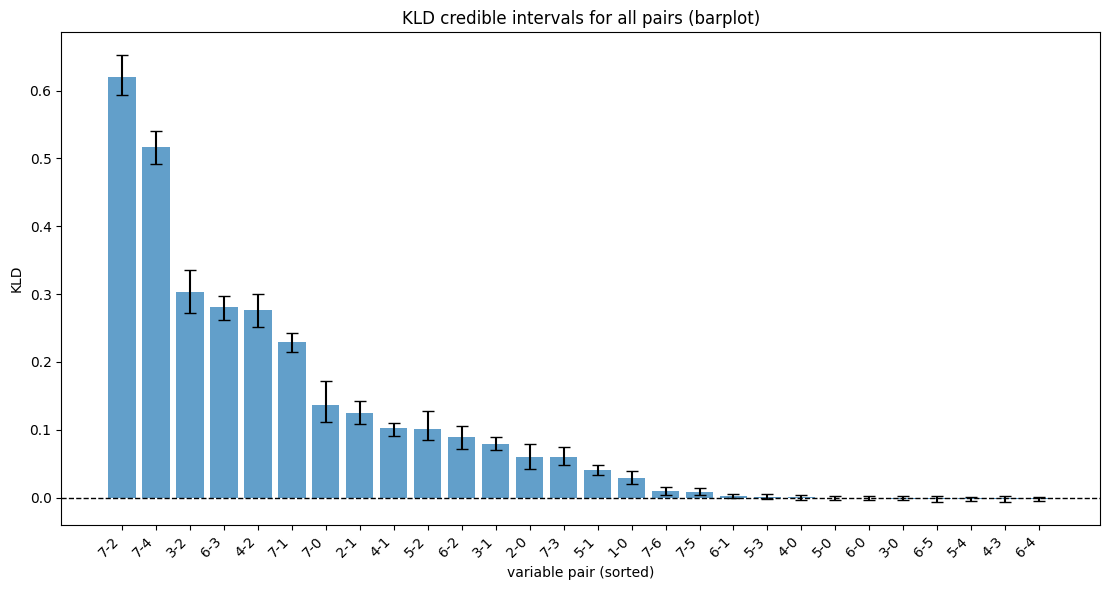

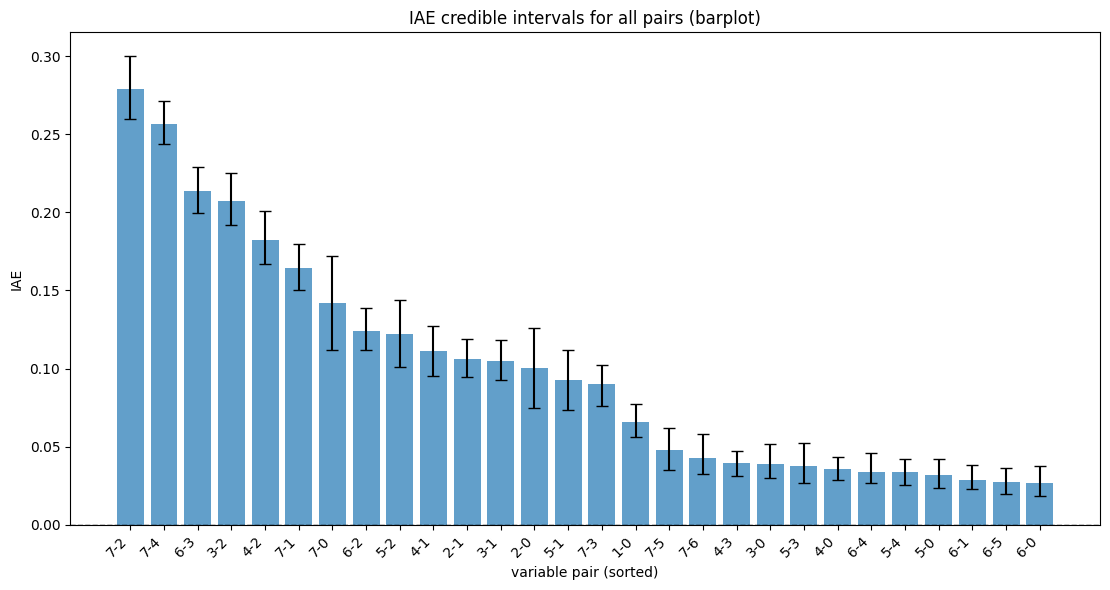

In [42]:
plot_metric_bar_ci(df_ci, metric="kld", log_scale=False)
plot_metric_bar_ci(df_ci, metric="iae", log_scale=False)


In [27]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


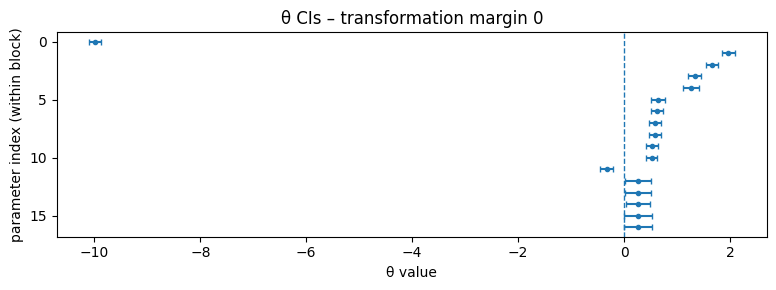

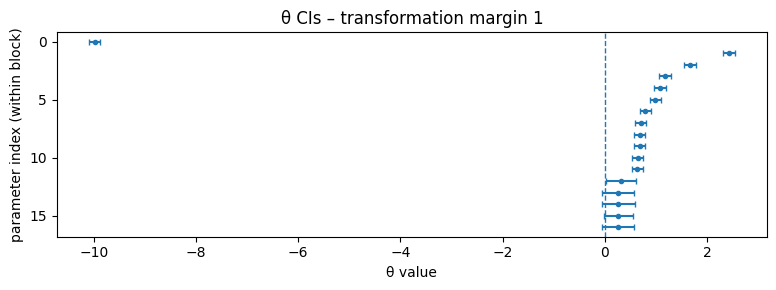

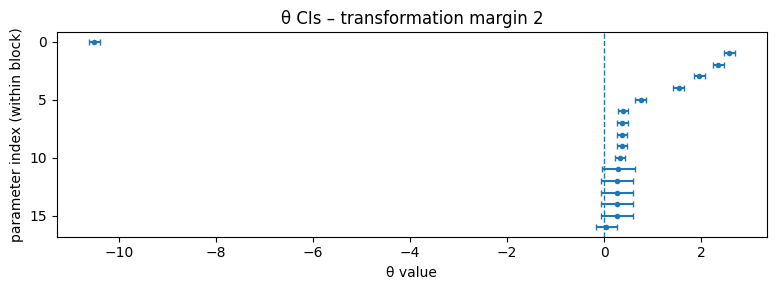

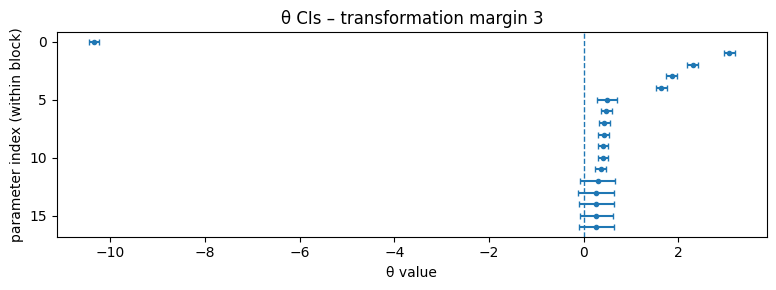

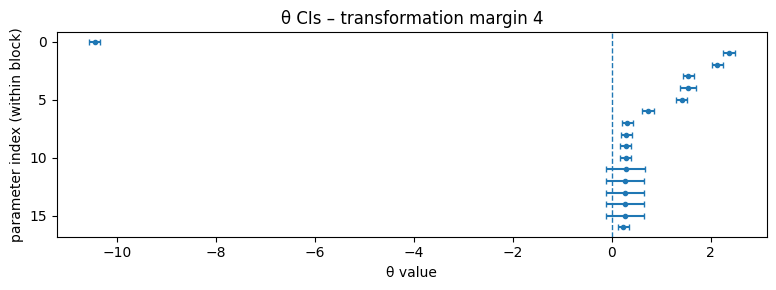

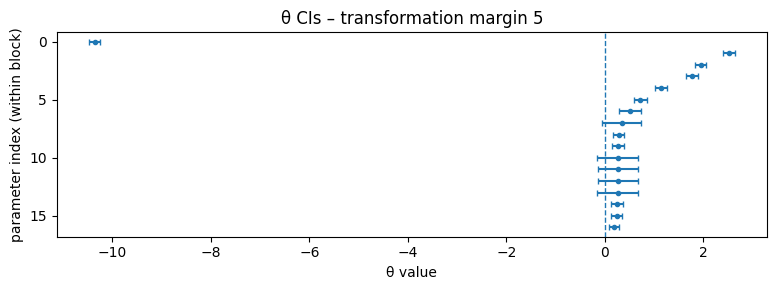

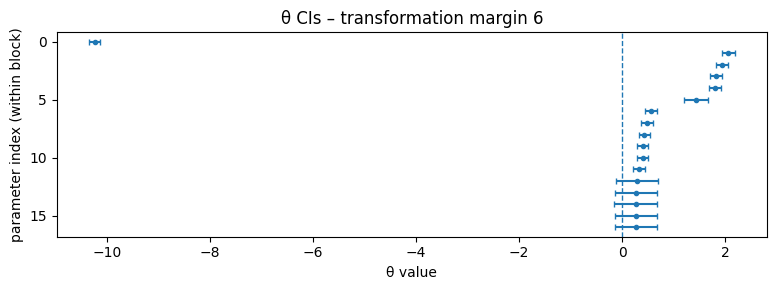

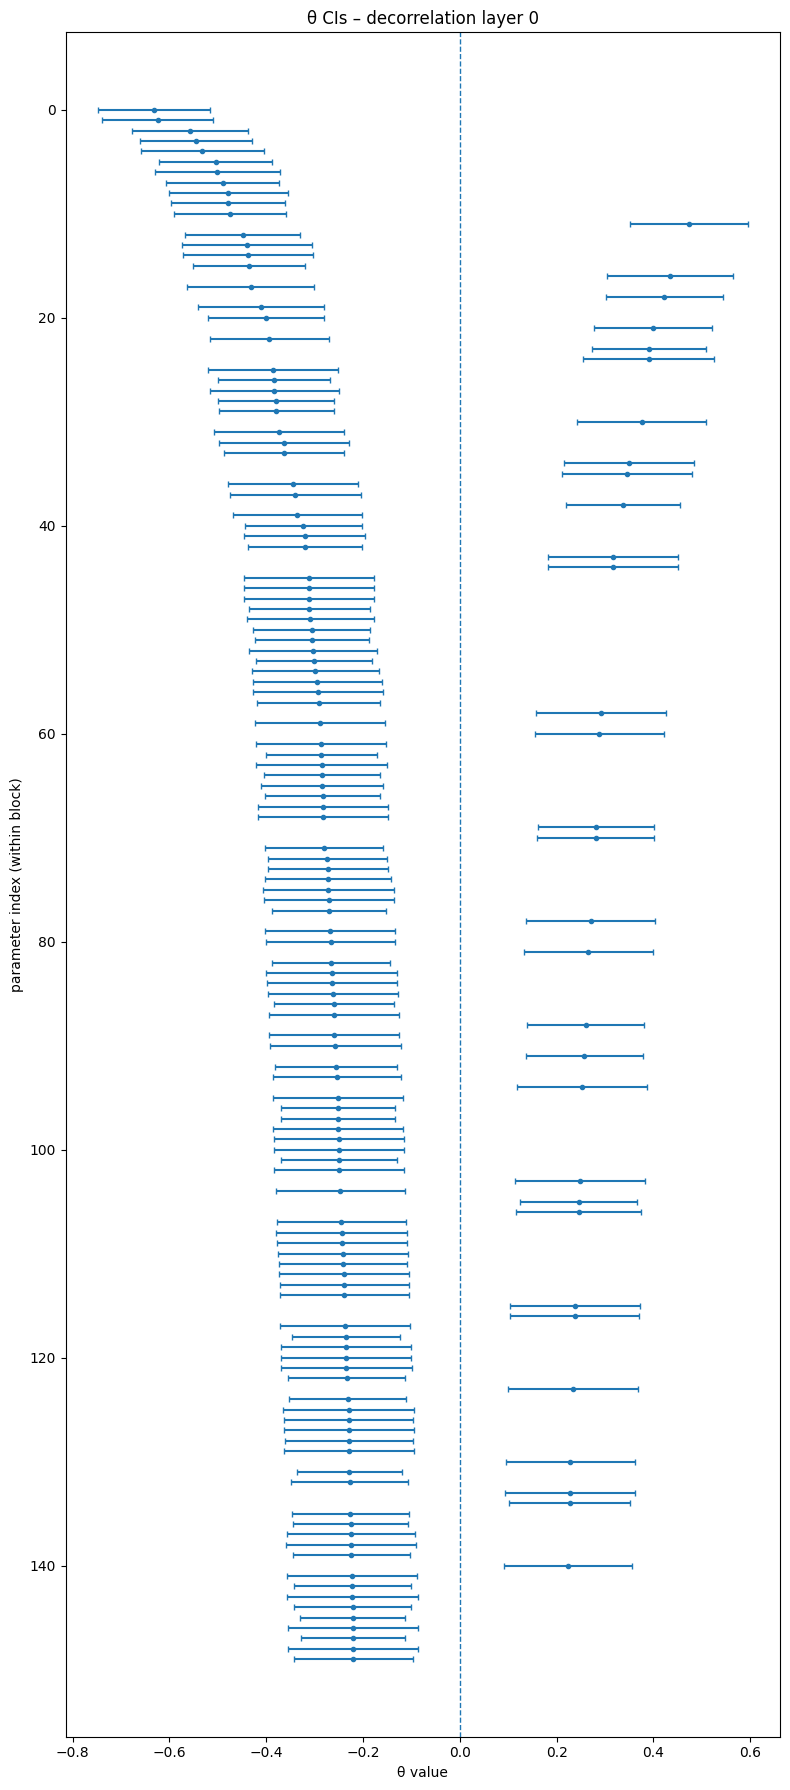

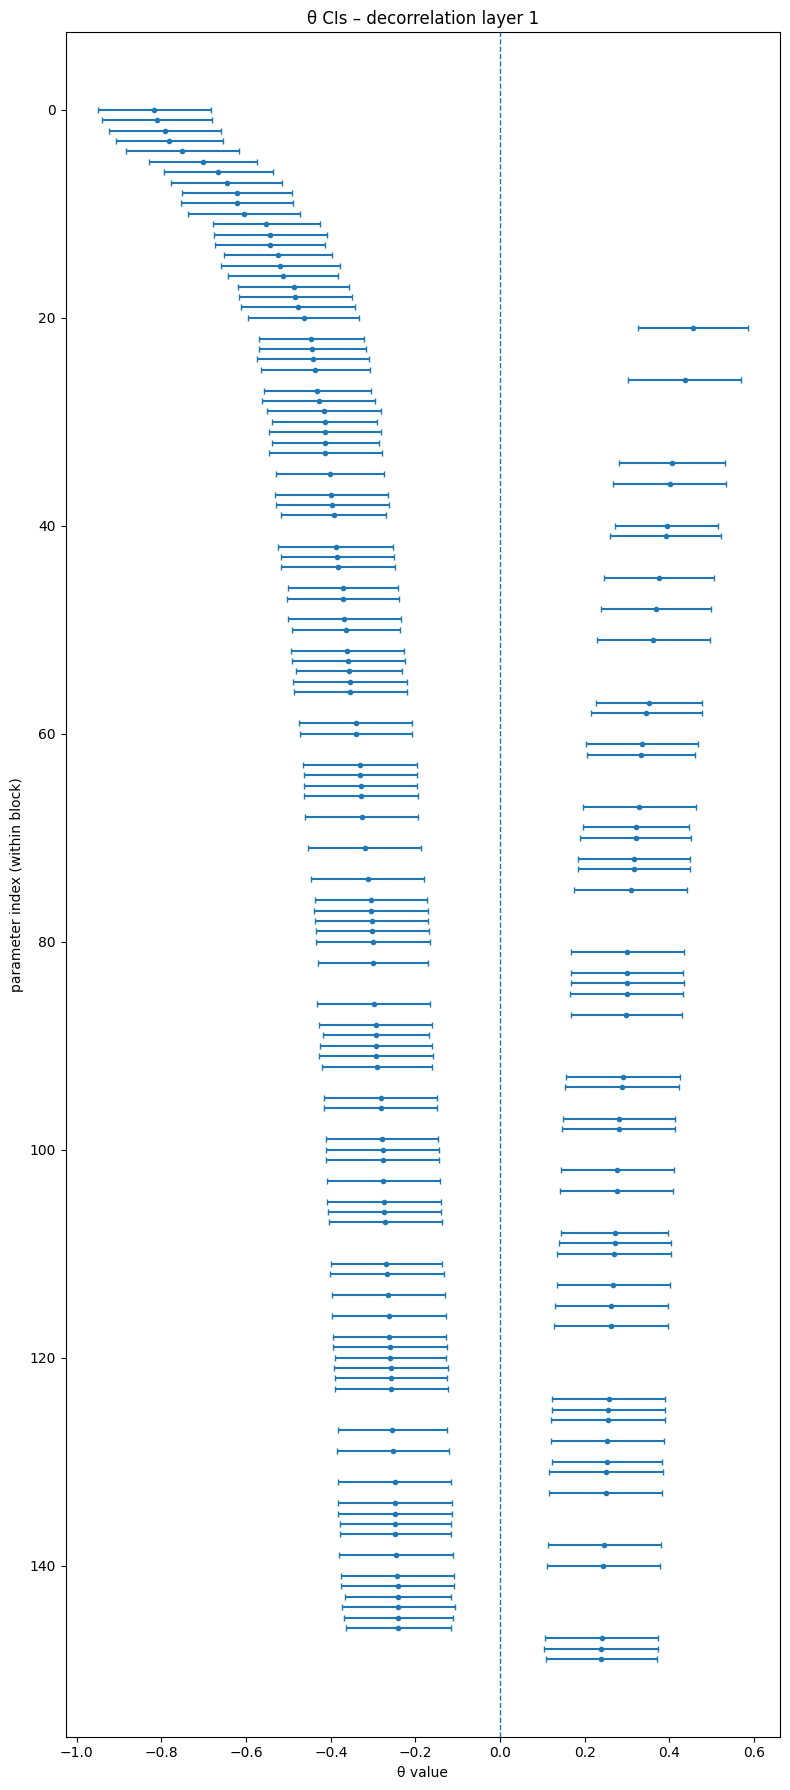

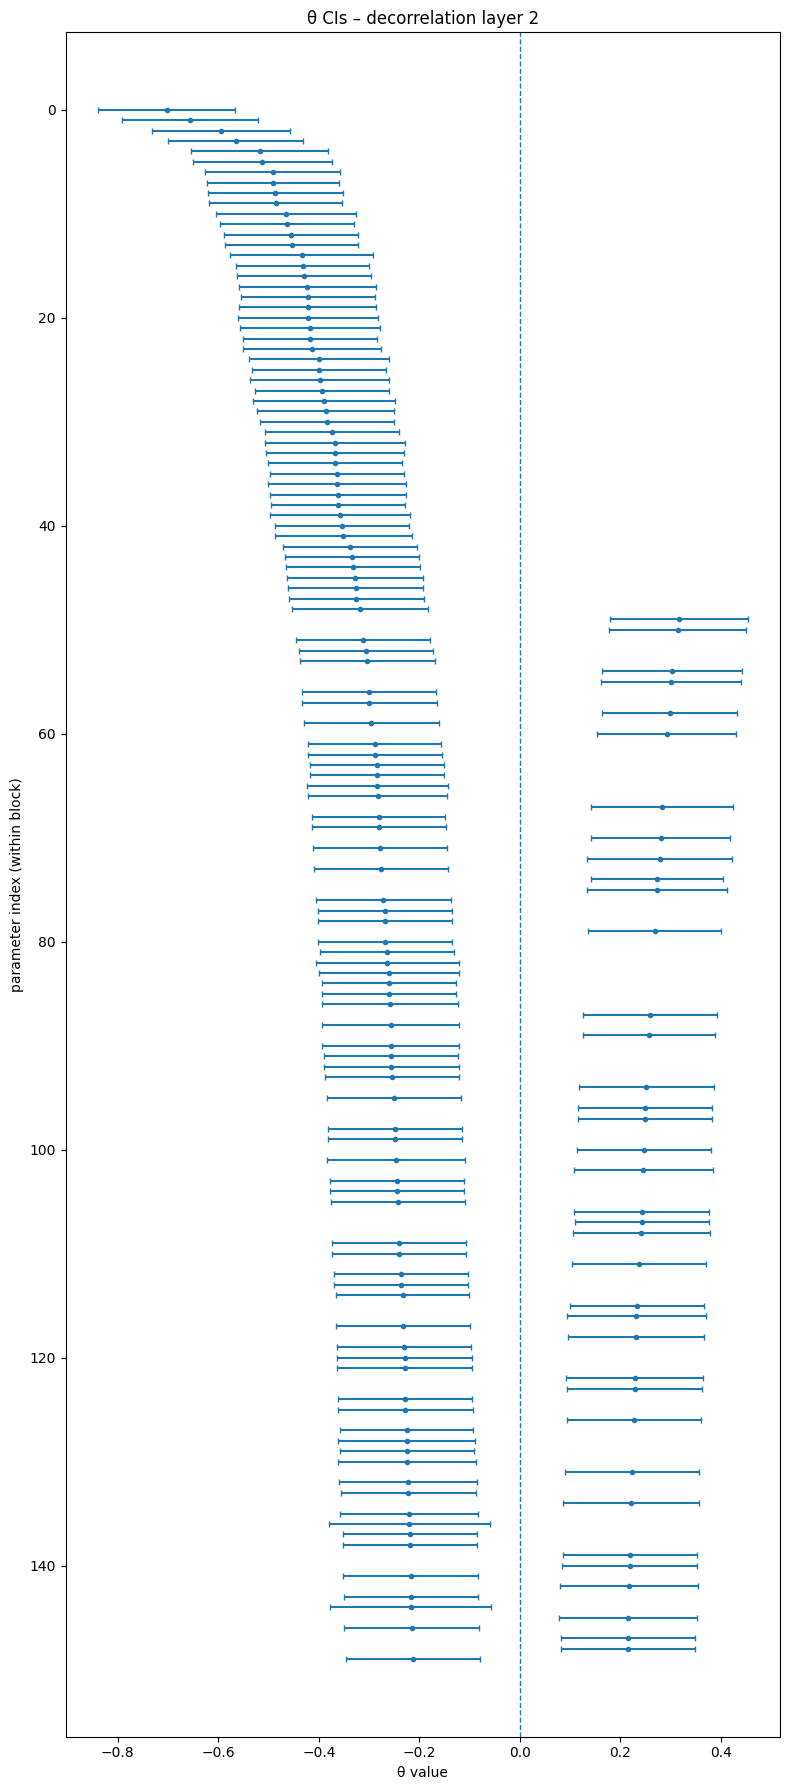

In [28]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


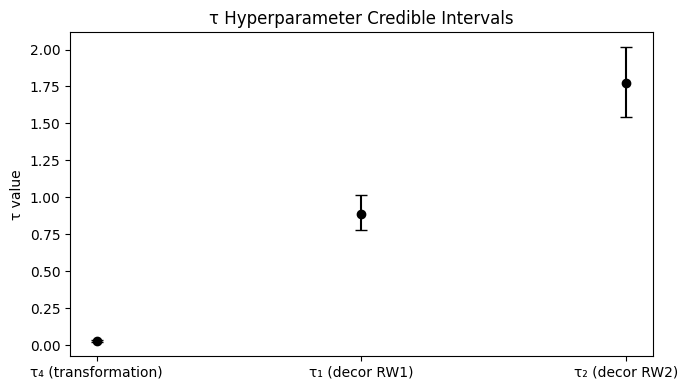

In [29]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [30]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


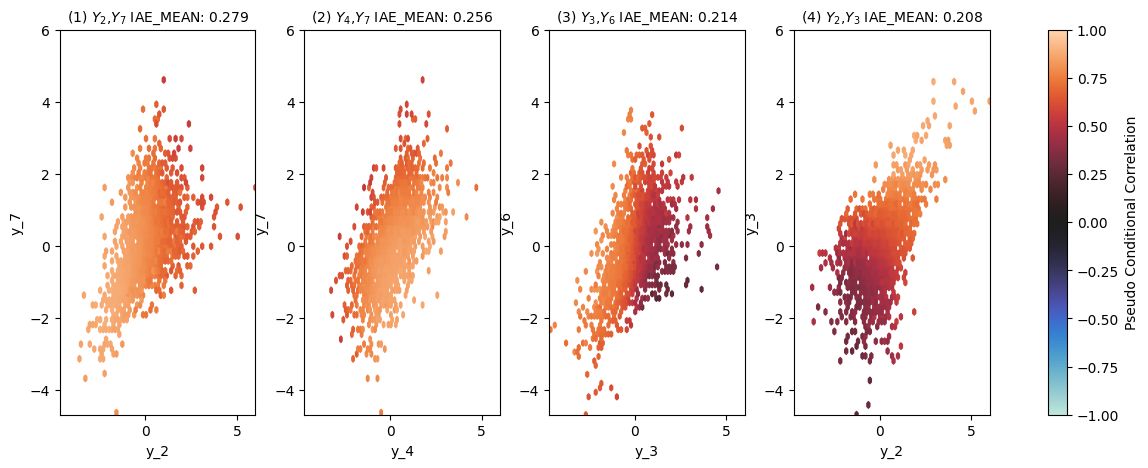

In [31]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

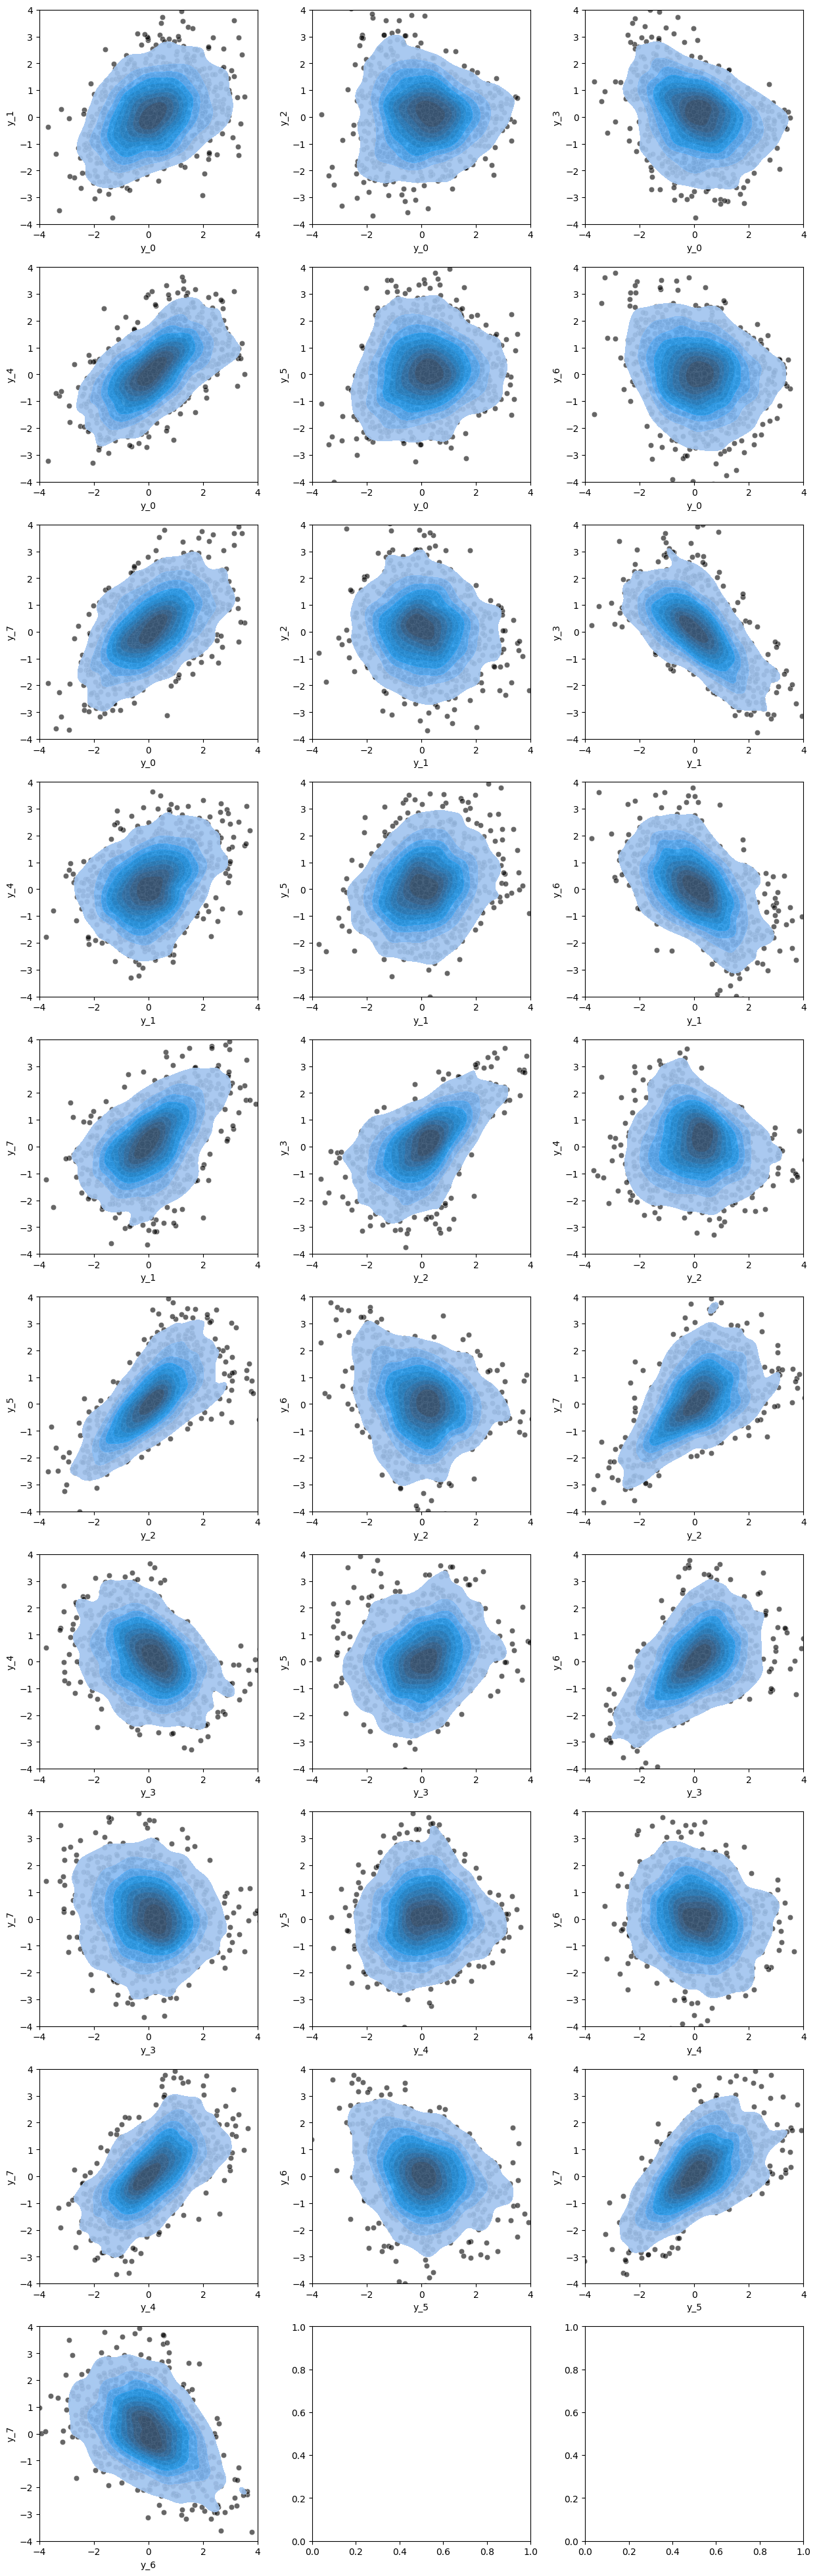

In [32]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [33]:
#model.plot_splines(layer_type="transformation")

In [34]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [35]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [36]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [37]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [38]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [ ]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,0.033935,-0.425835,0.014231,-0.297209,-0.343186,-0.373837,-0.369458,...,0.049808,-0.021346,-0.003831,0.088123,0.102901,0.103448,0.077176,0.090859,0.081007,0.243795
var_row,0.982607,1.000000,0.470238,0.046234,-0.439221,0.008356,-0.301077,-0.348982,-0.376833,-0.375441,...,0.066566,0.008356,0.015875,0.126725,0.144272,0.133688,0.093860,0.106950,0.099988,0.257133
var_col,0.619978,0.470238,1.000000,0.045398,-0.203317,0.062945,-0.133967,-0.154577,-0.187163,-0.176858,...,0.028409,-0.048740,-0.002507,-0.063223,-0.059046,-0.017825,0.037043,0.049297,0.028409,0.108266
abs_mean,0.033935,0.046234,0.045398,1.000000,-0.245211,0.911330,-0.342091,-0.312534,-0.309797,-0.309250,...,0.973727,0.956760,0.965517,0.910235,0.915709,0.915161,0.969896,0.971538,0.964423,0.731386
mean,-0.425835,-0.439221,-0.203317,-0.245211,1.000000,-0.086481,0.908593,0.926656,0.944718,0.955118,...,-0.257800,-0.255063,-0.263820,-0.215654,-0.207444,-0.225506,-0.271483,-0.252874,-0.282978,-0.155142
std,0.014231,0.008356,0.062945,0.911330,-0.086481,1.000000,-0.272031,-0.230980,-0.221675,-0.215654,...,0.859880,0.830870,0.831965,0.812808,0.820471,0.819923,0.869184,0.879584,0.858785,0.784577
min,-0.297209,-0.301077,-0.133967,-0.342091,0.908593,-0.272031,1.000000,0.992885,0.974275,0.972633,...,-0.347017,-0.340449,-0.348112,-0.291188,-0.290093,-0.290093,-0.375479,-0.359606,-0.374384,-0.341313
q_1,-0.343186,-0.348982,-0.154577,-0.312534,0.926656,-0.230980,0.992885,1.000000,0.985769,0.983580,...,-0.330049,-0.319650,-0.328955,-0.273673,-0.275315,-0.275862,-0.353585,-0.336617,-0.355227,-0.332448
q_5,-0.373837,-0.376833,-0.187163,-0.309797,0.944718,-0.221675,0.974275,0.985769,1.000000,0.996716,...,-0.319650,-0.309250,-0.316366,-0.275315,-0.276409,-0.281883,-0.345922,-0.325670,-0.353585,-0.323583
q_10,-0.369458,-0.375441,-0.176858,-0.309250,0.955118,-0.215654,0.972633,0.983580,0.996716,1.000000,...,-0.314724,-0.308155,-0.314724,-0.270936,-0.269294,-0.278599,-0.337712,-0.319102,-0.345922,-0.305852


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [ ]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9333333333333333
AUC KLD                    : 0.9282051282051282
AUC Conditional Correlation: 0.8923076923076924
AUC Precision Matrix       : 0.9384615384615385


We further print the ROC Curves for different metrics.

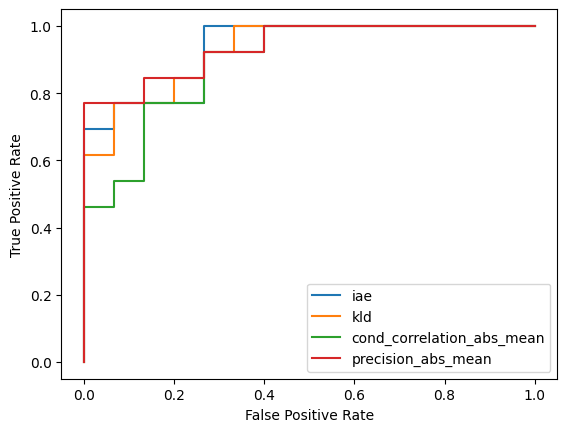

In [ ]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()